In [ ]:
import jax
import jax.numpy as jnp
import flax.linen as nn
import matplotlib.pyplot as plt
import flax
from typing import Any
import numpy as np
import functools
from einops import rearrange
import tqdm
import time
import optax

# Run the following if you're using Google Colab.
# !pip install git+https://github.com/kvfrans/jaxtransformer

# Classifiers

> A **classifier** is a model that is trained to categorize data into one of N distinct categories.

One of the simplest possible models to train is the **categorical classifier**. In this setting, we have a labelled dataset consisting of `(data, label) / (x,y)` pairs, where each **label** (y) is an integer representing one of N distinct classes. We would then like to train our classifier model such that it correctly predicts which class a given datapoint (x) falls into.

## Probability Maximization

To dervive the classification objective, we'll first note that **a classifier is an input-conditioned probability distribution over classes**. We want to fit the parameters of our classifier model to maximize the probability of samples from our dataset. To do this, we minimize the negative log-likelihood:

$$
L(\theta) = - \sum_{x, y \sim D} \log p_\theta(y|x).
$$

This loss function is also referred to as the **cross-entropy loss** in machine learning literature. The name refers to the fact that this loss is equivalent to information-theoretic cross-entropy between the data distribution and the model distribution.


## Model Structure

The final output of a neural network classifier must represent a probability distribution over classes. In the discrete categorical setting, this is simple -- the model can output a vector of probabilities, one for each possible class.

However, probability distributions must be positive and sum to one, and it is tricky to enforce these contraints in a neural network setting. Therefore, models are instead trained to output **logits**, which are unconstrained and real-valued. To get the probabilities from the logits, we exponentiate then explicitly normalize the values, dividing by their total sum. This operation is so common that is gets a special name, the **softmax** operation.

In [21]:
def softmax(logits, axis=-1): # [num_classes]
    return jnp.exp(logits) / jnp.sum(jnp.exp(logits), axis=axis, keepdims=True)
print("Softmax [1, 2, 3] = ", softmax(jnp.array([1, 2, 3])))

Softmax [1, 2, 3] =  [0.09003057 0.24472848 0.66524094]


<!-- Putting these together, we can now implement a basic classification loss function: -->

## Example: Imagenet Classification

To get a feel for a practical-size classifier, let's train a model that learns to classify the CIFAR-10 dataset, a set of 50,000 images with 10 classes.

Dataset size: (50000, 32, 32, 3)


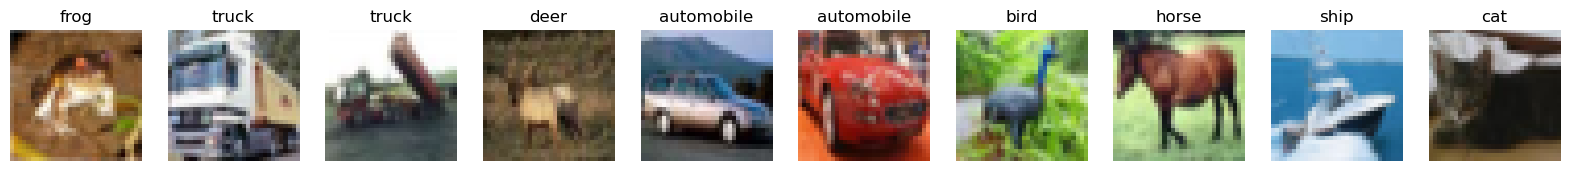

In [23]:
from jaxtransformer.transformer import TransformerBackbone
from jaxtransformer.modalities import PatchEmbed, ClassifierOutput, get_2d_sincos_pos_embed
from jaxtransformer.utils.train_state import TrainState

from keras.datasets import cifar10
(train_images, train_labels), (valid_images, valid_labels) = cifar10.load_data()
cifar_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
print('Dataset size:', train_images.shape)

fig, axs = plt.subplots(1, 10, figsize=(20, 5))
for i, ax in enumerate(axs):
    ax.imshow(train_images[i], cmap='gray')
    ax.title.set_text(f'{cifar_labels[train_labels[i].item()]}')
    ax.axis('off')

We'll train a transformer-based classifier, modelled after the [Vision Transformer (ViT)](https://arxiv.org/abs/2010.11929) line of models. We will use our homebrew `jaxtransformer` library to provide the backbone model implementation. 

Take a close look at `loss_fn`, which implements the classification objective we derived above. 

In [24]:
class Classifier(nn.Module):
    @nn.compact
    def __call__(self, x): # ViT-style classifier.
        x = x / 255.0
        x = PatchEmbed(patch_size=8, hidden_size=64)(x / 255.0)
        x = x + get_2d_sincos_pos_embed(None, 64, 16)
        class_token = nn.Embed(num_embeddings=1, features=64)(jnp.zeros((x.shape[0], 1), dtype=jnp.int32))
        x = jnp.concatenate([class_token, x], axis=1)
        x = TransformerBackbone(depth=4, num_heads=4, hidden_size=64, 
            use_conditioning=False, use_causal_masking=False, mlp_ratio=4)(x)
        x = nn.LayerNorm()(x)
        x = ClassifierOutput(num_classes=10)(x[:, 0, :])
        return x

def loss_fn(params, inputs, labels):
    logits = Classifier().apply({'params': params}, inputs)
    one_hot_labels = jax.nn.one_hot(labels, 10)
    probs = softmax(logits, axis=-1)
    log_probs = jnp.log(probs)
    accuracy = jnp.mean(jnp.argmax(logits, axis=-1) == labels)
    return -jnp.mean(jnp.sum(one_hot_labels * log_probs, axis=-1)), accuracy

In [30]:
# Generic model setup code.
model = Classifier()
tx = optax.adam(learning_rate=1e-3)
train_state = TrainState.create(jax.random.PRNGKey(0), model, (jnp.ones((1, 32, 32, 3)),), tx)

@jax.jit
def update_fn(train_state, batch):
    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (loss, accuracy), grad = grad_fn(train_state.params, batch[0], batch[1])
    updates, new_opt_state = train_state.tx.update(grad, train_state.opt_state, train_state.params)
    new_params = optax.apply_updates(train_state.params, updates)
    new_train_state = train_state.replace(params=new_params, opt_state=new_opt_state)
    return new_train_state, (loss, accuracy)

def plot(losses, accuracies, valid_losses, valid_accuracies):
    fig, axs = plt.subplots(1, 2, figsize=(8, 3))
    steps = np.arange(0, len(losses) * 300, 300)
    axs[0].plot(steps, losses, label='Train')
    axs[0].plot(steps, valid_losses, label='Valid')
    axs[0].legend()
    axs[0].title.set_text('Loss')
    axs[1].plot(steps, accuracies, label='Train')
    axs[1].plot(steps, valid_accuracies, label='Valid')
    axs[1].legend()
    axs[1].title.set_text('Accuracy')
    plt.show()

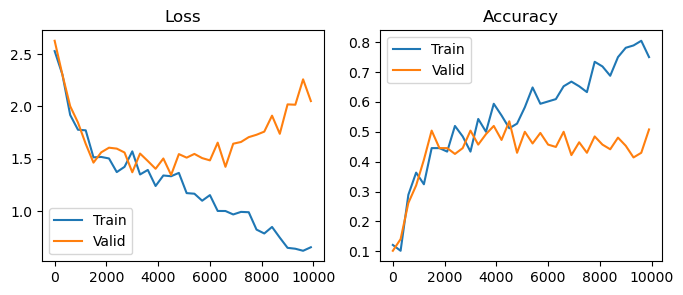

In [ ]:
rng = jax.random.PRNGKey(0)
losses, accuracies, valid_losses, valid_accuracies = [], [], [], []
for i in range(20000):
    rng, batch_key = jax.random.split(rng)
    idx = jax.random.randint(batch_key, (256,), 0, len(train_images))
    inputs, labels = train_images[idx], train_labels[idx, 0]
    train_state, (loss, accuracy) = update_fn(train_state, (inputs, labels))
    if i % 300 == 0:
        valid_idx = jax.random.randint(batch_key, (256,), 0, len(valid_images))
        inputs, labels = valid_images[valid_idx], valid_labels[valid_idx, 0]
        valid_loss, valid_accuracy = loss_fn(train_state.params, inputs, labels)
        losses.append(loss)
        accuracies.append(accuracy)
        valid_losses.append(valid_loss)
        valid_accuracies.append(valid_accuracy)
plot(losses, accuracies, valid_losses, valid_accuracies)

## Overfitting

You'll notice that around the 2000 training iteration mark, loss on the validation set begins to increase. This is a behavior known as **overfitting**, which is the key enemy in many classification problems. Overfitting occurs when the model learns features that are specific to the set of images it has been trained on, but don't properly generalize to new images. 

There are two main directions to combat overfitting. The first is **regularization** -- we can penalize the model and reduce its capacity. This is often done by reducing the model size, employing weight decay on the parameters, or by introducing dropout layers. The problem with regularization is that inherently we're reducing the effectiveness of our model.

The second direction is **data augmentation**. We can artificially increase our training data size by adding random augmentations to each data point. Typically, we'll use augmentations that we know won't change the ground-truth label -- for images, these are often rotations, crops, resizings, etc. By forcing the model to correctly categorize the dataset *under augmentation*, the model can't overfit as badly.

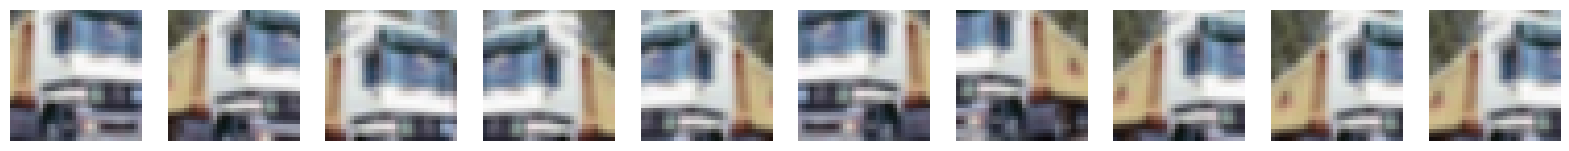

In [45]:
@jax.vmap
def img_augment(rng, img): # Randomly crop, resize, and flip.
    rng_x, rng_y, rng_flip = jax.random.split(rng, 3)
    rand_x = jax.random.randint(rng_x, (), 0, 8)
    rand_y = jax.random.randint(rng_y, (), 0, 8)
    crop = jax.lax.dynamic_slice(img, (rand_x, rand_y, 0), (24, 24, 3))
    img_size = jax.image.resize(crop, (32, 32, 3), method='bilinear')
    img_size = jax.lax.cond(jax.random.uniform(rng_flip) > 0.5, lambda x: x, functools.partial(jnp.flip, axis=1), img_size)
    return img_size

rngs = jax.random.split(rng, 10)
augments = img_augment(rngs, jnp.repeat(train_images[1:2], 10, axis=0))

fig, axs = plt.subplots(1, 10, figsize=(20, 5))
for i, ax in enumerate(axs):
    ax.imshow(augments[i] / 255.0, cmap='gray')
    ax.axis('off')

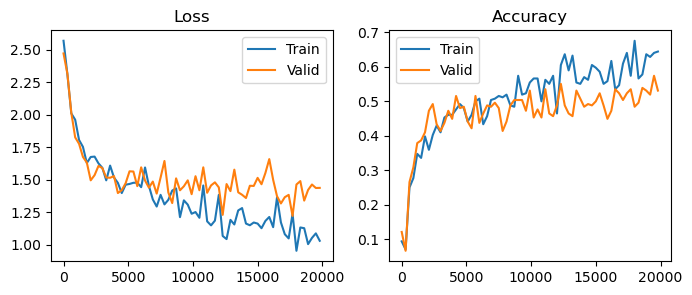

In [51]:
model = Classifier()
tx = optax.adamw(learning_rate=1e-3, weight_decay=1e-2)
train_state = TrainState.create(jax.random.PRNGKey(0), model, (jnp.ones((1, 32, 32, 3)),), tx)

rng = jax.random.PRNGKey(0)
losses, accuracies, valid_losses, valid_accuracies = [], [], [], []
for i in range(20000):
    rng, batch_key, aug_key = jax.random.split(rng, 3)
    idx = jax.random.randint(batch_key, (256,), 0, len(train_images))
    inputs, labels = train_images[idx], train_labels[idx, 0]
    inputs = img_augment(jax.random.split(aug_key, inputs.shape[0]), inputs)
    train_state, (loss, accuracy) = update_fn(train_state, (inputs, labels))
    if i % 300 == 0:
        valid_idx = jax.random.randint(batch_key, (256,), 0, len(valid_images))
        inputs, labels = valid_images[valid_idx], valid_labels[valid_idx, 0]
        valid_loss, valid_accuracy = loss_fn(train_state.params, inputs, labels)
        losses.append(loss)
        accuracies.append(accuracy)
        valid_losses.append(valid_loss)
        valid_accuracies.append(valid_accuracy)
plot(losses, accuracies, valid_losses, valid_accuracies)

## Why do we maximize log-probabilities instead of probabilities?

Because numerically, log-probabilities are easier to work with. First, note that the `log` function is monotonically increasing, so maximizing log-probabilities is equivalent to maximizing probabilites. Working in log space brings a number of numerical benefits. The log-probability of an independent joint distribution is the *sum* of individual log-probs, whereas raw probabilities would need to be multplied. Multiplication, especially of small values, will quickly become numerically unstable. We would much rather work with

$$
\sum_{y,x} \; \log p_\theta(y|x) \qquad \text{instead of} \qquad \prod_{y,x} \; p_\theta(y|x),
$$

and the optimal parameters are the same in either case.

## Why so some libraries subtract a constant in their softmax implementations?

The raw softmax function can be numerically unstable, as it involves an `exp` operator. To alleviate this problem, practical machine learning libraries tend to make use of a trick in the softmax equation: since the softmax is a ratio, we can scale all terms by a constant and get the same result. In logit-space, this means we can subtract a constant *before the exponent* and get the same result. Often, the maximum logit is subtracted from the logit vector, which lowers the risk that `exp` is called on a large number.

## What is the difference between binary cross-entropy and cross-entropy?

The term **binary cross-entropy** often arises when classifying data into two possible categories. The equation for binary cross-entropy is in fact the same as cross-entropy, just written in a slightly different way.

$$
\underbrace{\log p_\theta(y|x)}_{\text{cross-entropy}} = \sum_{y'} \log p_\theta(y'|x) * 𝟙(y' = y)  = \underbrace{\log p_\theta(y_1) * 𝟙(y_1 = y) + \log p_\theta(y_0) * 𝟙(y_0 = y)}_{\text{binary cross-entropy}}
$$

Additionally, the binary equivalent of the softmax activation is the **sigmoid** function, which gives the probability $p(y_1)$ from a real-valued logit, using the fact that for binary classification, $p(y_0) = 1 - p(y_1)$. Using $h_n$ to refer to logits for class labels $y_n$:

$$
\begin{align}
p(y) = \frac{exp(h)}{\sum_{h'} exp(h')} \qquad \rightarrow \qquad p(y_1) & = \frac{exp(h_1)}{exp(h_1) + exp(h_0)} \quad \text{(binary case)}. \\
& = \frac{1}{1 + exp(h_1 - h_0)} \\
& = \frac{1}{1 + e^{h}} \quad \text{(sigmoid function)}.
\end{align}
$$

Note for the binary case, probabilty is a function purely of the difference between logits $h_1$ and $h_0$, so we only need to learn a single logit.

## Can classification labels be not one-hot?

Yes, it's perfectly valid to have a dataset where labels are not one-hot, but rather full probability vectors. This is when the interpretation of minimizing cross-entropy between two distributions comes in helpful:

$$
L(\theta) = \sum_{x \sim D} \sum_{y'} \log p_\theta(y'|x) * p^*(y')
$$
where $p^(y')$ represents the probability vector given by the dataset, or a teacher mdoel, etc. Often, the inner sum over possible labels is computed in vectorized form as a dot product. Full probability targets are most often used in model distillation, to copy the behavior of a teacher model into a student model.

## A trick to sanity-check your classifier loss.

When a classifier is first initialized, it should roughly assign equal probability to every class. This means the average loss should be around `log(1/n_classes)`. As a sanity check, make sure your loss curves start at this value, or something is wrong! (https://karpathy.github.io/2019/04/25/recipe/)